<h1>LOAD ALL NECESSARY LIBRARIES</h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
# nltk.download('vader_lexicon')
import nltk.corpus
import os
import sys
import json
from collections import Counter
import swifter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import swifter
from ipywidgets import FloatProgress
from tqdm import tqdm

<h1>Load the json File</h1>

In [2]:
filename="Magazine_Subscriptions"

In [3]:
filepath = ('Datasets/'+filename+'.json')
df_raw = pd.read_json(filepath,lines=True)

In [4]:
df_raw.head()

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
0,5,9,False,"11 8, 2001",AH2IFH762VY5U,B00005N7P0,ted sedlmayr,"for computer enthusiast, MaxPC is a welcome si...","AVID READER SINCE ""boot"" WAS THE NAME",1005177600,NaN,NaN
1,5,9,False,"10 31, 2001",AOSFI0JEYU4XM,B00005N7P0,Amazon Customer,Thank god this is not a Ziff Davis publication...,The straight scoop,1004486400,NaN,NaN
2,3,14,False,"03 24, 2007",A3JPFWKS83R49V,B00005N7OJ,Bryan Carey,Antiques Magazine is a publication made for an...,"Antiques Magazine is Good, but not for Everyone",1174694400,{'Format:': ' Print Magazine'},NaN
3,5,13,False,"11 10, 2006",A19FKU6JZQ2ECJ,B00005N7OJ,Patricia L. Porada,This beautiful magazine is in itself a work of...,THE DISCERNING READER,1163116800,{'Format:': ' Print Magazine'},NaN
4,5,NaN,True,"07 14, 2014",A25MDGOMZ2GALN,B00005N7P0,Alvey,A great read every issue.,Five Stars,1405296000,NaN,NaN


<h1>Generate sentiment</h1>

In [5]:
# nltk.download('vader_lexicon')
sentiment = SentimentIntensityAnalyzer()
sid_obj = SentimentIntensityAnalyzer()
def get_compound_score(text):
    return sid_obj.polarity_scores(str(text))['compound']


df_raw['sentiment']=df_raw['reviewText'].swifter.apply(get_compound_score)

count=0
avg_rating=0
comp_rating=0
for index, row in df_raw.iterrows():
    ss = sentiment.polarity_scores(str(row['reviewText']))
    for k in sorted(ss):
        compound_score =ss['compound']
    
    avg_rating+=(compound_score+1)/2.0*5.0
    comp_rating+=(row.overall+compound_score/5.0)*(5/6)
    count+=1
    
# Calculate final average rating if count is greater than 0 to avoid division by zero
if count > 0:
    avg_rating /= count
    comp_rating /= count


Pandas Apply:   0%|          | 0/89689 [00:00<?, ?it/s]

<h1>Save and Load the Sentiment file</h1>

In [6]:
#Backup all the modifications in csv file
df_raw.to_csv('output/'+filename+'.csv', index=False)
df_raw=pd.read_csv('output/'+filename+'.csv')

C:\Users\SUBHASHIS\AppData\Local\Temp\ipykernel_27096\2721690646.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw=pd.read_csv('output/'+filename+'.csv')


In [7]:
df_raw['reviewTime'] = pd.to_datetime(df_raw['unixReviewTime'], unit='s')
df_raw.head()

,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image,sentiment
0,5,9,False,2001-11-08,AH2IFH762VY5U,B00005N7P0,ted sedlmayr,"for computer enthusiast, MaxPC is a welcome si...","AVID READER SINCE ""boot"" WAS THE NAME",1005177600,NaN,NaN,0.9630
1,5,9,False,2001-10-31,AOSFI0JEYU4XM,B00005N7P0,Amazon Customer,Thank god this is not a Ziff Davis publication...,The straight scoop,1004486400,NaN,NaN,0.5106
2,3,14,False,2007-03-24,A3JPFWKS83R49V,B00005N7OJ,Bryan Carey,Antiques Magazine is a publication made for an...,"Antiques Magazine is Good, but not for Everyone",1174694400,{'Format:': ' Print Magazine'},NaN,0.9931
3,5,13,False,2006-11-10,A19FKU6JZQ2ECJ,B00005N7OJ,Patricia L. Porada,This beautiful magazine is in itself a work of...,THE DISCERNING READER,1163116800,{'Format:': ' Print Magazine'},NaN,0.8932
4,5,NaN,True,2014-07-14,A25MDGOMZ2GALN,B00005N7P0,Alvey,A great read every issue.,Five Stars,1405296000,NaN,NaN,0.6249


<h1>Now group by reviewTime for 1 Week</h1>
<p>reviewCount-> count all reviews in a week</p>
<p>sentiment-> mean of all sentiments for diff products in a week</p>
<p>overall->mean of all ratings in a week</p>
<p>helpfulness->count of the number of people who liked the review</p>

In [8]:

df_grouped = df_raw.groupby(pd.Grouper(key='reviewTime', freq='7D')).agg(
    review_count=('reviewerID', 'count'),
    average_sentiment=('sentiment', 'mean'),
    average_rating=('overall', 'mean'),
    helpfulness=('vote','count')
).reset_index()

In [9]:
df_grouped=df_grouped.fillna(0)
df_grouped.set_index('reviewTime', inplace=True)
df_grouped.head()

,review_count,average_sentiment,average_rating,helpfulness
reviewTime,,,,
2001-10-26,134,0.815234,4.373134,103
2001-11-02,27,0.794089,4.555556,24
2001-11-09,14,0.870700,4.428571,14
2001-11-16,17,0.846706,4.411765,16
2001-11-23,26,0.756819,4.153846,24


In [10]:
df_grouped.tail(20)

,review_count,average_sentiment,average_rating,helpfulness
reviewTime,,,,
2018-05-04,136,0.289907,3.529412,3
2018-05-11,113,0.498224,4.000000,1
2018-05-18,42,0.449026,4.238095,0
2018-05-25,26,0.627235,4.230769,1
2018-06-01,25,0.608864,4.080000,1
2018-06-08,25,0.380692,3.600000,0
2018-06-15,29,0.413914,4.068966,1
2018-06-22,26,0.669746,4.500000,0
2018-06-29,10,0.616100,4.800000,0


In [11]:
# See average sentiment
print(df_grouped['average_sentiment'].min(),df_grouped['average_sentiment'].max())

-0.13075000000000003 0.97385


In [12]:
min_sentiment=df_grouped['average_sentiment'].min()
max_sentiment=df_grouped['average_sentiment'].max()

In [13]:
df_grouped['average_sentiment']=1+(df_grouped['average_sentiment']-min_sentiment)*(5-1)/(max_sentiment-min_sentiment)

In [14]:
df_grouped.tail(2)

,review_count,average_sentiment,average_rating,helpfulness
reviewTime,,,,
2018-09-07,6,2.437262,4.0,0
2018-09-14,2,3.387833,5.0,0


In [15]:

max_value = df_grouped['helpfulness'].max()
min_value = df_grouped['helpfulness'].min()

df_grouped['helpfulness']=1+ (df_grouped['helpfulness']-min_value)*(4)/(max_value-min_value)

In [16]:
print(df_grouped['helpfulness'].min(),df_grouped['helpfulness'].max())

1.0 5.0


In [17]:
df_grouped.tail(6)

,review_count,average_sentiment,average_rating,helpfulness
reviewTime,,,,
2018-08-10,4,4.191834,4.75,1.0
2018-08-17,3,3.169292,5.00,1.0
2018-08-24,4,4.192287,3.75,1.0
2018-08-31,2,1.000000,3.00,1.0
2018-09-07,6,2.437262,4.00,1.0
2018-09-14,2,3.387833,5.00,1.0


In [18]:
df_grouped['mixture']=df_grouped['helpfulness']*df_grouped['average_sentiment']*df_grouped['average_rating']

In [19]:

max_value = df_grouped['mixture'].max()
min_value = df_grouped['mixture'].min()

print(min_value,max_value)

3.0 96.7691034801428


In [20]:
df_grouped['mixture']=1+ (df_grouped['mixture']-min_value)*(4)/(max_value-min_value)

In [21]:
df_grouped.tail()

,review_count,average_sentiment,average_rating,helpfulness,mixture
reviewTime,,,,,
2018-08-17,3,3.169292,5.00,1.0,1.548004
2018-08-24,4,4.192287,3.75,1.0,1.542655
2018-08-31,2,1.000000,3.00,1.0,1.000000
2018-09-07,6,2.437262,4.00,1.0,1.287901
2018-09-14,2,3.387833,5.00,1.0,1.594616


In [22]:
print(df_grouped['mixture'].max(),df_grouped['mixture'].min())


5.0 1.0


In [23]:
max_value = df_grouped['review_count'].max()
min_value = df_grouped['review_count'].min()

print(min_value,max_value)
df_grouped['review_count']=1+ (df_grouped['review_count']-min_value)*(4)/(max_value-min_value)

2 528


<h1>Now training the models</h1>

In [24]:
#  split train/valid/test
n = len(df_grouped)
train_end = int(n * 0.7)
val_end = n - int(n * 0.1)
test_end = n

In [25]:
print("Total dataset length=",n);
print("Datasets to be trained upon:",train_end);
print("Datasets to be validated upon:",val_end-train_end);
print("Datasets to be tested upon:",test_end-val_end);

Total dataset length= 882
Datasets to be trained upon: 617
Datasets to be validated upon: 177
Datasets to be tested upon: 88


In [26]:
seq_len=16
pred_len=60
batch_size=60

df_grouped_bak=df_grouped

df_grouped_bak['review_count'] = np.log(df_grouped_bak['review_count']+1)

log_min = df_grouped_bak['review_count'].min()
log_max = df_grouped_bak['review_count'].max()


df_grouped_bak=df_grouped_bak/10


In [27]:
df_grouped_bak['review_count']

reviewTime
2001-10-26    0.109988
2001-11-02    0.078395
2001-11-09    0.073776
2001-11-16    0.074861
2001-11-23    0.078048
                ...   
2018-08-17    0.069694
2018-08-24    0.070072
2018-08-31    0.069315
2018-09-07    0.070824
2018-09-14    0.069315
Name: review_count, Length: 882, dtype: float64

In [28]:
# df_grouped_bak['review_count']

In [29]:
sum(df_grouped_bak.mixture<0)

0

In [30]:
train_df = df_grouped_bak[:train_end]
val_df = df_grouped_bak[train_end - seq_len: val_end]
test_df = df_grouped_bak[val_end - seq_len: test_end]

In [31]:
def _split_window(data,target_slice=slice(0,None)):
    inputs = data[:, : seq_len, :]
    labels = data[:, seq_len :, target_slice]
    inputs.set_shape([None, seq_len, None])
    labels.set_shape([None, pred_len, None])
    return inputs, labels

def _make_dataset(data, shuffle=True, targets=None):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=targets,
        sequence_length=(seq_len + pred_len),
        sequence_stride=5,
        shuffle=shuffle,
        batch_size=batch_size,
    )
    ds = ds.map(_split_window)
    return ds

def get_train(self, shuffle=True):
    return self._make_dataset(self.train_df, shuffle=shuffle)


In [32]:
import tensorflow as tf
train_data  =   _make_dataset(train_df, shuffle=False)
val_data    =   _make_dataset(val_df, shuffle=False)
test_data   =   _make_dataset(test_df, shuffle=False)

In [33]:
from tensorflow.keras import layers

def res_block(inputs, ff_dim):

  norm = layers.LayerNormalization

  # Time mixing
  x = norm(axis=[-2, -1])(inputs)
  x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Channel, Input Length]
  x = layers.Dense(x.shape[-1], activation='relu')(x)
  x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Input Length, Channel]
  x = layers.Dropout(0.6)(x)
  res = x + inputs

  # Feature mixing
  x = norm(axis=[-2, -1])(res)
  x = layers.Dense(ff_dim, activation='relu')(x)  # [Batch, Input Length, FF_Dim]
  x = layers.Dropout(0.6)(x)
  x = layers.Dense(inputs.shape[-1])(x)  # [Batch, Input Length, Channel]
  x = layers.Dropout(0.6)(x)
  return (x + res ) #* (avg_rating/5.0) * (comp_rating/5.0)

In [34]:
def build_model(
    input_shape,
    pred_len,
    n_block,
    ff_dim,
    target_slice,
):

  inputs = tf.keras.Input(shape=input_shape)
  x = inputs  # [Batch, Input Length, Channel]
  for _ in range(n_block):
    x = res_block(x, ff_dim)

  if target_slice:
    x = x[:, :, target_slice]

  # Temporal projection
  x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Channel, Input Length]
  x = layers.Dense(pred_len)(x)  # [Batch, Channel, Output Length]
  outputs = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Output Length, Channel])

  return tf.keras.Model(inputs, outputs)

In [35]:
n_feature = train_df.shape[-1]
model = build_model(
    input_shape=(seq_len, n_feature),
    pred_len=pred_len,
    n_block=16,
    ff_dim=64,
    target_slice=slice(0,None)
)

In [36]:
from tensorflow.keras.callbacks import ModelCheckpoint
# tf.keras.utils.set_random_seed(7)
tf.keras.utils.set_random_seed(7)

initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=24,
    decay_rate=0.97,
    staircase=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer, loss='mse', metrics=['mse'])
checkpoint_callback = ModelCheckpoint(
    'best_model.h5',           
    monitor='val_mse',        
    save_best_only=True,       # Save only the best model (lowest val_loss)
    mode='min',                
    verbose=1,
)

In [37]:
history = model.fit(
    train_data,
    epochs= 1000,
    validation_data=test_data,
    callbacks=[checkpoint_callback]
)

Epoch 1/1000
1/2 [==============>...............] - ETA: 9s - loss: 25.9457 - mse: 25.9457
Epoch 1: val_mse improved from inf to 2.15648, saving model to best_model.h5
2/2 [==============================] - 12s 2s/step - loss: 101.7789 - mse: 101.7789 - val_loss: 2.1565 - val_mse: 2.1565
Epoch 2/1000
1/2 [==============>...............] - ETA: 0s - loss: 4.1369 - mse: 4.1369
Epoch 2: val_mse did not improve from 2.15648
2/2 [==============================] - 0s 114ms/step - loss: 46.4312 - mse: 46.4312 - val_loss: 30.9595 - val_mse: 30.9595
Epoch 3/1000
2/2 [==============================] - ETA: 0s - loss: 30.9489 - mse: 30.9489
Epoch 3: val_mse did not improve from 2.15648
2/2 [==============================] - 0s 119ms/step - loss: 30.9489 - mse: 30.9489 - val_loss: 3.1439 - val_mse: 3.1439
Epoch 4/1000
1/2 [==============>...............] - ETA: 0s - loss: 9.0165 - mse: 9.0165
Epoch 4: val_mse did not improve from 2.15648
2/2 [==============================] - 0s 107ms/step - loss:

In [38]:
from tensorflow.keras.models import load_model
model = load_model('best_model.h5')
predictions = model.predict(test_data)

scaled_preds = predictions[-1,:,:]

scaled_preds.shape

cols = ['review_count','average_sentiment','average_rating','helpfulness','mixture']
scaled_preds_df = pd.DataFrame(scaled_preds)
scaled_preds_df.columns = cols


1/1 [==============================] - 2s 2s/step


In [40]:
df_grouped

,review_count,average_sentiment,average_rating,helpfulness,mixture
reviewTime,,,,,
2001-10-26,1.099879,4.425618,4.373134,5.000000,5.000000
2001-11-02,0.783954,4.349045,4.555556,1.932039,2.504895
2001-11-09,0.737764,4.626471,4.428571,1.543689,2.221218
2001-11-16,0.748614,4.539583,4.411765,1.621359,2.257211
2001-11-23,0.780475,4.214084,4.153846,1.932039,2.314705
...,...,...,...,...,...
2018-08-17,0.696942,3.169292,5.000000,1.000000,1.548004
2018-08-24,0.700723,4.192287,3.750000,1.000000,1.542655
2018-08-31,0.693147,1.000000,3.000000,1.000000,1.000000


average_sentiment
average_rating
helpfulness
mixture


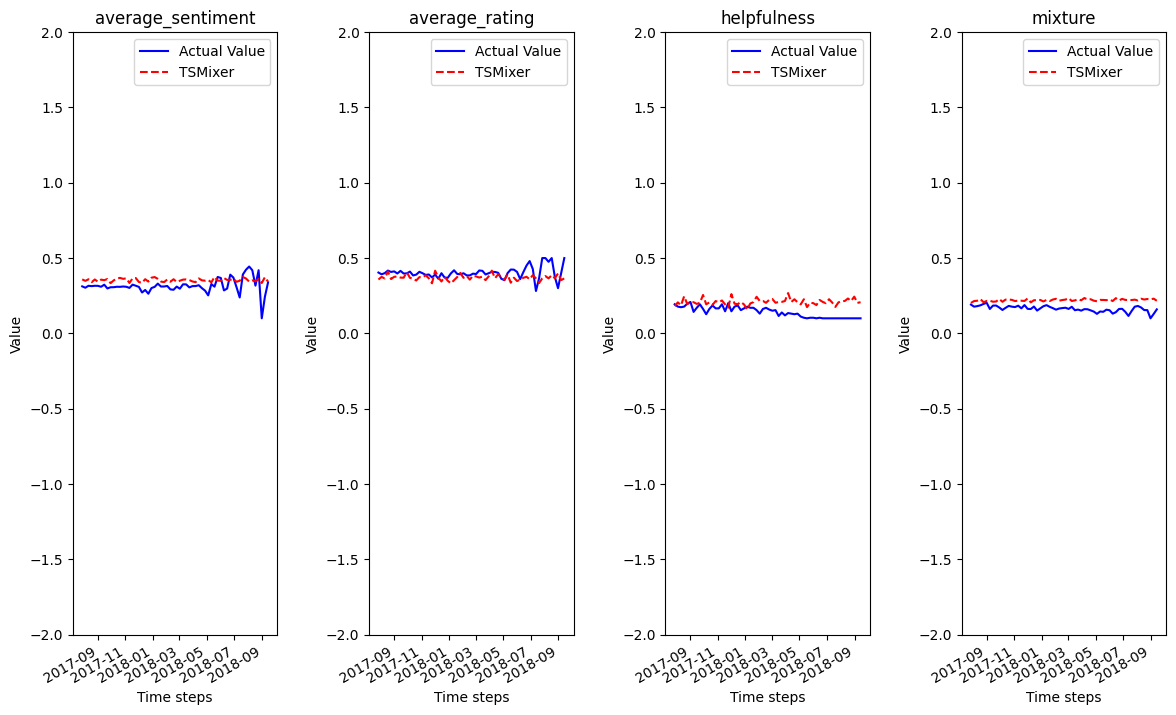

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,8))

for i, ax in enumerate(axes.flatten()[0:4]):
    col = cols[i+1]
    print(col)
    ax.plot(df_grouped.index[-pred_len:], df_grouped_bak[col][-pred_len:], label = 'Actual Value', color='blue')
    ax.plot(df_grouped.index[-pred_len:], scaled_preds_df[col], label='TSMixer', ls='--', color='red')
    
    ax.legend(loc='best')
    ax.set_xlabel('Time steps')
    ax.set_ylabel('Value')
    ax.set_ylim(-2, 2) 
    ax.set_title(col)
    
plt.tight_layout()
fig.autofmt_xdate()

plt.savefig('RESULT_'+filename+'.jpg')

<h1>MSE</h1>

In [42]:
for column in cols[1:5]:
    mse = ((df_grouped_bak[column][-pred_len:].values - scaled_preds_df[column].values) ** 2).mean()
    print('MSE('+column+')='+str(round(mse*100,5))+'%')

MSE(average_sentiment)=0.38079%
MSE(average_rating)=0.29095%
MSE(helpfulness)=0.63219%
MSE(mixture)=0.37804%


In [43]:
actual_values = df_grouped_bak[column][-pred_len:].values
print(actual_values<0)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]


<h1>MSLE</h1>

In [44]:
for column in cols[1:5]:
    msle = ((np.log1p(df_grouped_bak[column][-pred_len:].values) - np.log1p(scaled_preds_df[column].values)) ** 2).mean()
    print('MSLE('+column+')='+str(round(msle*100,5))+'%')

MSLE(average_sentiment)=0.22575%
MSLE(average_rating)=0.14791%
MSLE(helpfulness)=0.46425%
MSLE(mixture)=0.26875%


<h1>MAPE</h1>

In [48]:
for column in cols[1:5]:
    mape= (abs((df_grouped_bak[column][-pred_len:].values - scaled_preds_df[column].values) / df_grouped_bak[column][-pred_len:].values)).mean() * 100
    print('MAPE('+column+')='+str(round(mape,5))+'%')
    

MAPE(average_sentiment)=19.50779%
MAPE(average_rating)=9.95398%
MAPE(helpfulness)=58.13578%
MAPE(mixture)=37.33507%


In [46]:
df_raw.shape

(89689, 13)